In [2]:
import os
import torch
import time
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import random
import torch.nn as nn
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torch.autograd import Variable
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
from torch.utils.tensorboard import SummaryWriter 
from efficientnet_pytorch import EfficientNet

In [3]:
np.random.seed(2020)
torch.manual_seed(2020)

In [ ]:
# path to chexpert dataset with structure outlined in the project description
data_path = '/data'

train_csv_path = data_path + '/chexpert/v1.0/train.csv'
valid_csv_path = data_path + '/chexpert/v1.0/valid.csv'
dir_path = data_path + '/chexpert/v1.0/'

#path to the directory with saved state dictionaries
model_path = '/checkpoints_efficientNet'

# Data preparation

In [5]:
# data pre-processing, combining training set and test set, only use frontal images.
train_csv = pd.read_csv(train_csv_path, sep=',').fillna(0)
valid_csv = pd.read_csv(valid_csv_path, sep=',').fillna(0)
train_csv = train_csv[~train_csv[train_csv.columns[3]].str.contains("Lateral")]
valid_csv = valid_csv[~valid_csv[valid_csv.columns[3]].str.contains("Lateral")]

#this image is lost
pa = 'CheXpert-v1.0/train/patient40761/study1/view1_frontal.jpg'
train_csv = train_csv[~train_csv[train_csv.columns[0]].str.contains(pa)]

# drop other information 
train_csv = train_csv.drop(['Sex', 'Age', 'Frontal/Lateral', 'AP/PA'], axis=1)
valid_csv = valid_csv.drop(['Sex', 'Age', 'Frontal/Lateral', 'AP/PA'], axis=1)

# Transforms

In [6]:
normTransform = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_transform = transforms.Compose([
    transforms.Resize((480, 480)),
    transforms.RandomCrop(456),
    transforms.RandomRotation(7),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    normTransform
])

test_transform = transforms.Compose([
    transforms.Resize((456, 456)),
    transforms.ToTensor(),
])

# Dataset and dataloader

In [7]:
class Datasets(Dataset):
    
    def __init__(self, state, transform=None):
        self.path = state.iloc[1:,0].values
        labels = state.iloc[1:, 1:].values
        for row in range(labels.shape[0]):
            for column in range(labels.shape[1]):
                if labels[row][column] != 0.0 and labels[row][column] != 1.0:
                    labels[row][column] = round(np.random.uniform(0.55, 0.85), 2)
        self.labels = labels
        
        self.transform = transform
        
    def __getitem__(self, index):
        img_path = self.path[index]
        img_path = img_path.replace('CheXpert-', 'chexpert/')
        image = Image.open(os.path.join(data_path, img_path)).convert('RGB')
        label = self.labels[index]
        
        if self.transform:
            image = self.transform(image)
            
        return image, torch.FloatTensor(label)
            
    def __len__(self):
        return self.path.shape[0]

In [8]:
train_data = Datasets(train_csv, train_transform)
val_data = Datasets(valid_csv, test_transform)

# put it into dataloader
batch_size = 6
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

# Model

In [4]:
class Efficientnet(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.net = EfficientNet.from_pretrained('efficientnet-b5')
        self.net._fc = nn.Sequential(nn.Linear(2048, 14), nn.Sigmoid())
        
    def forward(self,x):
        
        return self.net(x)

# Model

In [5]:
model = Efficientnet()

Loaded pretrained weights for efficientnet-b5


# Loss function and optimizer

In [10]:
loss = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999))
learning_rate_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5, last_epoch=-1)

Loaded pretrained weights for efficientnet-b5


Pick only 5 diseases of interest

In [11]:
labels_name = train_csv.columns[1:].values
target = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']
target_index = [list(labels_name).index(item) for item in target]
target_index

[8, 2, 6, 5, 10]

For warm start load state dictionary in cell below and set **epoch_start** in next cell to corresponding epoch number

In [11]:
old = os.path.join(model_path, 'epoch_7_score_0.8841.pth' )
model.load_state_dict(torch.load(old)['state_dict'])
optimizer.load_state_dict(torch.load(old)['optimizer'])

In [35]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.001
    lr: 1.953125e-06
    weight_decay: 0
)

# Training

In [ ]:
target_scores = []
target_score_averages = []
new_scores = []

# use tensorboard to record
writer = SummaryWriter()

epoch_start = 8
num_epoch = 40
best_score = 0.0
for epoch in range(epoch_start, num_epoch):
    
    epoch_star = time.time()
    train_loss = 0.0
    val_loss = 0.0
    val_pred = torch.FloatTensor().cuda()     # Tensor stores prediction values
    val_label = torch.FloatTensor().cuda()       # Tensor stores true values
    
    model.train()
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        train_prd = model(data[0].cuda())
        batch_loss = loss(train_prd, data[1].cuda())
        batch_loss.backward()
        optimizer.step()

        # tensorboard for batch loss
        train_loss += batch_loss.item()
        index_train = len(train_loader) * epoch + i
        writer.add_scalar('batch_loss', batch_loss.item() , index_train)
    
    model.eval()
    with torch.no_grad():
        for j,data in enumerate(val_loader):
            prd = model(data[0].cuda())
            batch_loss = loss(prd, data[1].cuda())

            val_loss += batch_loss.item()
            val_pred = torch.cat((val_pred, prd), 0)
            val_label = torch.cat((val_label, data[1].cuda()), 0)
      
    learning_rate_scheduler.step()
    
    #tensorboard for score and train loss
    target_score = [roc_auc_score(val_label.cpu().numpy()[:, i], val_pred.detach().cpu().numpy()[:, i],average='macro', multi_class='ovo') for i in target_index]
    target_scores.append(target_score)
    target_score_average = roc_auc_score(val_label.cpu().numpy()[:, target_index], val_pred.detach().cpu().numpy()[:, target_index],average='macro', multi_class='ovo')
    target_score_averages.append(target_score_average)
#     new_score = roc_auc_score(val_label.cpu().numpy(), val_pred.detach().cpu().numpy(),average='macro', multi_class='ovo')
#     new_scores.append(new_score)
    
    train_loss = train_loss/len(train_loader)

    best_score = target_score_average.round(5)
    torch.save({'state_dict': model.state_dict(), 'optimizer' : optimizer.state_dict()}, os.path.join(model_path, f'epoch_{epoch}_score_{best_score}.pth'))
        
    writer.add_scalars('train/val for epochs', {'train_loss':np.array(train_loss), \
                                               'val_target':np.array(target_score_average),\
                                               'val_loss': np.array(val_loss)}, epoch)


writer.close()

# Evaluation
Load model weights file from directory **model_path** 

In [ ]:
file_name = 'epoch_2_score_0.87939.pth'

In [ ]:
target_scores = []
target_score_averages = []
valid_loss = []

model.load_state_dict(torch.load(os.path.join(model_path, file_name))['state_dict'])

val_pred = torch.FloatTensor().cuda()     # Tensor stores prediction values
val_label = torch.FloatTensor().cuda()       # Tensor stores true values

val_loss = 0.0
with torch.no_grad():
    for j,data in enumerate(val_loader):
                prd = model(data[0].cuda())
                batch_loss = loss(prd, data[1].cuda())

                val_loss += batch_loss.item()
                val_pred = torch.cat((val_pred, prd), 0)
                val_label = torch.cat((val_label, data[1].cuda()), 0)




target_score= [roc_auc_score(val_label.cpu().numpy()[:, i], val_pred.detach().cpu().numpy()[:, i],average='macro', multi_class='ovo') for i in target_index]
target_score_average = roc_auc_score(val_label.cpu().numpy()[:, target_index], val_pred.detach().cpu().numpy()[:, target_index],average='macro', multi_class='ovo')
target_score_averages.append(target_score_average)
val = val_loss/len(val_loader)
valid_loss.append(val)

In [23]:
target_score, target_score_averages

([0.8349206349206348,
  0.8218325791855203,
  0.8920118343195267,
  0.9351602276130577,
  0.9343065693430657],
 [0.883646369076361])

Text(0, 0.5, 'validation loss')

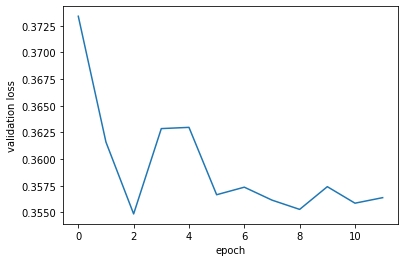

In [14]:
plt.plot(np.arange(12), valid_loss)
plt.xlabel('epoch')
plt.ylabel('validation loss')

Text(0, 0.5, 'auc_score')

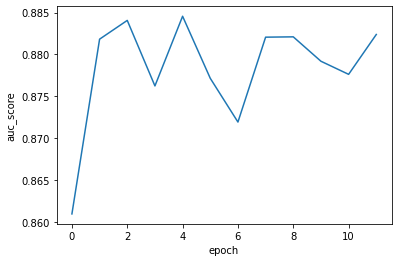

In [15]:
plt.plot(np.arange(12), target_score_averages)
plt.xlabel('epoch')
plt.ylabel('auc_score')

In [16]:
target_score_averages

[0.8609299799312247,
 0.8818131754637344,
 0.8840559314683609,
 0.8762259145198563,
 0.8845531858380102,
 0.8771368069451153,
 0.8719094716485651,
 0.882052253647889,
 0.8820918625851455,
 0.8791750016961786,
 0.8776101132850564,
 0.882372800490762]